In [2]:
GEMs_taxonomy = pd.read_csv("/BioII/lulab_b/jinyunfan/projects/terminator-prediction/rho-protein-phylogenetics/reference-genomes/otu_taxonomy.tsv",sep="\t",index_col=0)

In [15]:
from scipy.interpolate import interp1d
import os
import numpy as np
import pandas as pd
from scipy.stats import ranksums
from scipy.stats import kruskal

In [6]:
rho_domains = pd.read_csv("data/rho-hmm-hits.txt",sep="\t")

In [82]:
rho_domains_full = rho_domains[(rho_domains["domain hit"].map(lambda x:"Rho_ATPase" in str(x)))&((rho_domains["domain hit"].map(lambda x:"Rho_RNA_bind" in str(x))))]

In [84]:
def aggregate_by_otu(t):
    protein_ids = ",".join(t["protein id"].values)
    return pd.Series({"protein id":protein_ids})

In [85]:
rho_domains_full = rho_domains_full.groupby("otu id").apply(aggregate_by_otu)

In [86]:
genome_to_otu = pd.read_csv("/data2/lulab1/microbiome/MAGs/GEMs/metadata/genome_to_otu.tsv",sep="\t")
representative_genomes = pd.read_csv("/data2/lulab1/microbiome/MAGs/GEMs/metadata/otu_representative_genomes.tsv",sep="\t",index_col=0)
representative_genomes = genome_to_otu[genome_to_otu["genome_id"].isin(representative_genomes["genome_id"])]
representative_genomes = representative_genomes.set_index("otu_id")
representative_genomes["taxonomy"] = GEMs_taxonomy.loc[representative_genomes.index,"taxonomy"]

In [103]:
representative_genomes.to_csv("genome-information.txt",sep="\t")

In [87]:
detected_rho_proteins = rho_domains_full['protein id'].to_dict()

In [88]:
representative_genomes["rho homologs"] = representative_genomes.index.map(lambda x:detected_rho_proteins.get(x,"."))

In [89]:
representative_genomes["phylum"] = representative_genomes["taxonomy"].map(lambda x:x.split(";")[1][3:])

In [90]:
representative_genomes_refseq = representative_genomes[representative_genomes["study"] == "NCBI-RefSeq"]

In [100]:
detected_rho_proteins["OTU-21876"]

'NZ_FNTS01000002.1_3039'

In [128]:
indir = "data/rho-downstream-sequences"
otu_id2sequence = {}
for fasta in os.listdir(indir):
    path = os.path.join(indir, fasta)
    with open(path) as f:
        for header in f:
            otu_id = header[1:].split(":")[0]
            sequence = next(f)
            otu_id2sequence[otu_id] = sequence.strip()

In [129]:
representative_genomes["downstream sequences"] = representative_genomes.index.map(lambda x:otu_id2sequence.get(x,"."))
representative_genomes_with_rho_downstream = representative_genomes.sort_values(by="taxonomy").copy()
representative_genomes_with_rho_downstream = representative_genomes_with_rho_downstream[representative_genomes_with_rho_downstream['downstream sequences'] != "."]

In [130]:
representative_genomes_with_rho_downstream.to_csv("rho-downstream-sequences.txt",sep="\t")

3.664

In [414]:
def extract_score(chunk_id, otu_id):    
    best_scores = {}
    best_prediction = {}
    distances = np.zeros(500)
    bed = f"data/RUTs/{chunk_id}/{otu_id}.bed"
    with open(bed) as f:
        for line in f:
            fields = line.strip().split("\t")
            seq_id = fields[0]
            p = seq_id.rfind(":")
            protein_id = seq_id[p+1:]
            seq_id = seq_id[:p]        
            fields[0] = seq_id
            start, end = int(fields[1]), int(fields[2])
            score = float(fields[6])        
            if (protein_id not in best_scores) or (best_scores[protein_id] < score):
                best_scores[protein_id] = score
                best_prediction[protein_id] = fields  
    N = 0
    with open(f"data/terminators-flanking/{chunk_id}/{otu_id}.fa.fai") as f:
        for line in f:
            N += 1

    combined_score = 0            
    for protein_id in best_prediction:
        fields = best_prediction[protein_id]
        seq_id = fields[0]
        s, e = seq_id[:-3].split(":")[-1].split("-")
        s, e = int(s), int(e)
        length = e - s
        # offset is end of the stem loop
        offset = length - 300
        start, end = int(fields[1]), int(fields[2])
        #start, end = start - offset, end - offset 
        score = float(fields[6])    
        #print(score)
        combined_score += score
        if start < 0:
            continue    
        distances[start:end] += 1  
    #print(combined_score/N)    
    fig, ax = plt.subplots(figsize=(4,3))            
    ax.plot(distances)
    ax.set_xlim([0,200])
    return combined_score/N

1.367462568472308

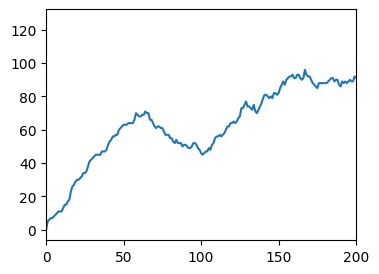

In [415]:
extract_score("239","OTU-23934")

In [416]:
genome_information = pd.read_csv("genome-information.txt",sep="\t",index_col=0)

In [426]:
checkm = pd.read_csv("/data2/lulab1/microbiome/MAGs/GEMs/metadata/genome_to_checkm.tsv",sep="\t",index_col=0)

In [432]:
genome_information.loc[:,"completeness"] = checkm.loc[genome_information['genome_id'].values,"completeness"].values
genome_information.loc[:,"contamination"] = checkm.loc[genome_information['genome_id'].values,"contamination"].values

In [418]:
otu_id2score = {}
for txt in os.listdir("data/RUT-scores"):
    path = os.path.join("data/RUT-scores",txt)
    with open(path) as f:
        for line in f:
            otu_id, score, axtonomy = line.strip().split("\t")
            otu_id2score[otu_id] = float(score)

In [422]:
genome_information["rho scores"] = genome_information.index.map(lambda x:otu_id2score.get(x,np.nan))

In [1560]:
pwd

'/BioII/lulab_b/jinyunfan/projects/terminator-prediction/terminator-evoluationary-analysis'

In [435]:
metadata = pd.read_csv("data/terminators/000/OTU-10.txt",sep="\t",index_col=0)

In [469]:
CDS_counts = {}
for chunk_id in os.listdir("data/CDS"):
    for bed in os.listdir(f"data/CDS/{chunk_id}"):
        path = f"data/CDS/{chunk_id}/{bed}"
        otu_id = bed[:-4]
        N = 0
        with open(path) as f:
            for line in f:
                N += 1
        CDS_counts[otu_id] = N

In [460]:
genome_information = genome_information.join(stem_loop_statistics)

In [472]:
CDS_counts = pd.Series(CDS_counts)
genome_information.loc[:,"CDS counts"] = CDS_counts.loc[genome_information.index]

In [479]:
from collections import defaultdict

In [480]:
lengths = {}
for chunk_id in sorted(os.listdir("data/lengths")):
    print(chunk_id)
    for size in os.listdir(f"data/lengths/{chunk_id}"):
        path = f"data/lengths/{chunk_id}/{size}"
        otu_id = size[:-5]
        length = 0
        with open(path) as f:
            for line in f:
                length += int(line.strip().split("\t")[-1])
        lengths[otu_id] = length

000
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
071
072
073
074
075
076
077
078
079
080
081
082
083
084
085
086
087
088
089
090
091
092
093
094
095
096
097
098
099
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


In [483]:
lengths = pd.Series(lengths)

In [484]:
genome_information.loc[:,"genome size"] = lengths.loc[genome_information.index]

In [493]:
genome_information = genome_information.join(stem_loop_statistics)

In [494]:
genome_information.to_csv("combined-statistics.txt",sep="\t")

In [506]:
import seaborn as sns

In [597]:
def categorize_U_counts(x):
    if x <= 3:
        return "<=3"
    elif x <= 5:
        return "4-5"
    elif x <= 7:
        return "6-7"
    elif x <= 9:
        return "8-9"
    else:
        return ">=10"

In [587]:
from pandas.api.types import CategoricalDtype

In [825]:
mask1 = genome_information['contamination'] < 5
mask2 = genome_information['completeness'] > 95
mask3 = ~genome_information['U count'].isna()
mask4 = genome_information["taxonomy"].map(lambda x:x.startswith("d__Bacteria"))
mask5 = genome_information["type"] == "isolate"

In [817]:
passed_genome_information[passed_genome_information["rho scores"].isna()]

,genome_id,type,study,taxonomy,rho homologs,phylum,rho scores,completeness,contamination,CDS counts,genome size,stem length,loop length,U count,number,contain rho,U lengths
otu_id,,,,,,,,,,,,,,,,,


In [826]:
passed_genome_information = genome_information[mask1&mask2&mask3&mask4&mask5]
passed_genome_information.loc[:,"contain rho"] = (passed_genome_information.loc[:,"rho homologs"]!=".").astype(int)
passed_genome_information.loc[:,"U lengths"] = passed_genome_information.loc[:,"U count"].map(categorize_U_counts).copy()
U_lengths_cat = CategoricalDtype(categories=["<=3","4-5","6-7","8-9",">=10"], ordered=True)
passed_genome_information.loc[:,'U lengths'] = passed_genome_information.loc[:,'U lengths'].astype(U_lengths_cat)
passed_genome_information = passed_genome_information.sort_values(by="U lengths")

/tmp/ipykernel_127935/2151455385.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passed_genome_information.loc[:,"contain rho"] = (passed_genome_information.loc[:,"rho homologs"]!=".").astype(int)
/tmp/ipykernel_127935/2151455385.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passed_genome_information.loc[:,"U lengths"] = passed_genome_information.loc[:,"U count"].map(categorize_U_counts).copy()


In [1557]:
groupped_rho_dependency_scores = list(passed_genome_information.groupby("U lengths").apply(lambda x:list(x["rho scores"].values)).values)

In [1559]:
kruskal(*groupped_rho_dependency_scores)

KruskalResult(statistic=13234.522686809112, pvalue=0.0)

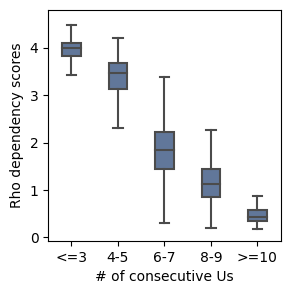

In [828]:
fig, ax = plt.subplots(figsize=(3,3))
sns.boxplot(data=passed_genome_information.sort_values(by="U lengths"),
            x="U lengths",y="rho scores",ax=ax,order=["<=3","4-5","6-7","8-9",">=10"],
            color="#5875A3",width=0.4,fliersize=0)
#sns.stripplot(data=passed_genome_information.sort_values(by="U lengths"),
#            x="U lengths",y="rho scores",ax=ax,order=["<=3","4-5","6-7","8-9",">=10"],
#            color="black",s=0.3,jitter=0.2,alpha=0.1)
ax.set_xlabel("# of consecutive Us")
ax.set_ylabel("Rho dependency scores")
plt.savefig("figures/U-length-rho-dependency-score-association.pdf",bbox_inches="tight")

In [1549]:
x = passed_genome_information[passed_genome_information['contain rho'] == 0]['rho scores'].values
y = passed_genome_information[passed_genome_information['contain rho'] == 1]['rho scores'].values

In [1551]:
ranksums(x,y)

RanksumsResult(statistic=-34.6758278790271, pvalue=1.8233870292614654e-263)

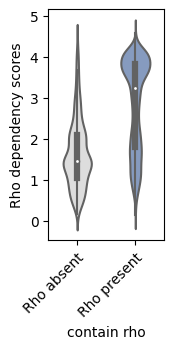

In [846]:
fig, ax = plt.subplots(figsize=(1.5,3))
sns.violinplot(data=passed_genome_information,x="contain rho",y="rho scores",ax=ax,width=0.5,palette=["#DDDDDD","#7C99C9"])
ax.set_xticklabels(["Rho absent","Rho present"])
ax.set_ylabel("Rho dependency scores")
_ = plt.setp(ax.get_xticklabels(),fontsize=10,rotation_mode="anchor",ha="right",rotation=45)
plt.savefig("figures/rho-presence-score-association.pdf",bbox_inches="tight")

In [830]:
passed_genome_information_wt_rho = passed_genome_information[passed_genome_information["contain rho"] == 1]
passed_genome_information_wo_rho = passed_genome_information[passed_genome_information["contain rho"] == 0]

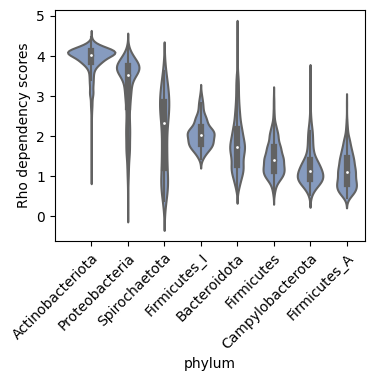

In [844]:
phylum_wt_rho_to_visualize = passed_genome_information_wt_rho.groupby("phylum").apply(lambda x:x.shape[0]).sort_values(ascending=False).index[:8]
passed_genome_information_wt_rho_to_show = passed_genome_information_wt_rho[passed_genome_information_wt_rho["phylum"].isin(phylum_wt_rho_to_visualize)]
order = passed_genome_information_wt_rho_to_show.groupby("phylum").apply(lambda x:x['rho scores'].median()).sort_values(ascending=False).index
fig, ax = plt.subplots(figsize=(4,3))
sns.violinplot(data=passed_genome_information_wt_rho_to_show,x="phylum",y="rho scores",ax=ax,order=order,width=1.3,
               color="#7C99C9",edgecolor="black")#palette=sns.color_palette("Blues"))
ax.set_xlim([-1,7.5])
_ = plt.setp(ax.get_xticklabels(),fontsize=10,rotation_mode="anchor",ha="right",rotation=45)
ax.set_ylabel("Rho dependency scores")
plt.savefig("figures/with-rho-score-by-clade.pdf",bbox_inches="tight")

In [832]:
phylum_wo_rho_to_visualize = passed_genome_information_wo_rho.groupby("phylum").apply(lambda x:x.shape[0]).sort_values(ascending=False).index[:4]
passed_genome_information_wo_rho_to_show = passed_genome_information_wo_rho[passed_genome_information_wo_rho["phylum"].isin(phylum_wo_rho_to_visualize)]

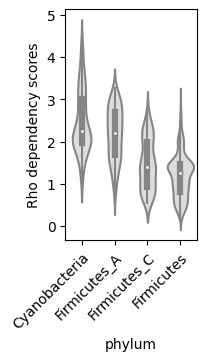

In [845]:
fig, ax = plt.subplots(figsize=(1.7,3))
sns.violinplot(data=passed_genome_information_wo_rho_to_show,x="phylum",y="rho scores",order=['Cyanobacteria', 'Firmicutes_A', 'Firmicutes_C', 'Firmicutes'],
               ax=ax,color="#DDDDDD")#,palette=sns.color_palette("Blues"))
_ = plt.setp(ax.get_xticklabels(),fontsize=10,rotation_mode="anchor",ha="right",rotation=45)
ax.set_ylabel("Rho dependency scores")
plt.savefig("figures/without-rho-score-by-clade.pdf",bbox_inches="tight")

In [837]:
!wc -l considered-genome-ids.txt

15539 considered-genome-ids.txt


In [835]:
with open("considered-genome-ids.txt","w") as f:
    f.write("\n".join(passed_genome_information.index))

In [734]:
#DATASET_SCALE,1-line 1-#dddddd-1-1-1,2-line 2-#ff0000-1-0-2,3-line 3-#00ff00-5-1-1
#1-line 1-#dddddd-1-1-1
#1: position
#line 1: name
##dddddd: color
#1: width
#1: dashed, 0 is not dashed
#1: label size factor

In [838]:
otu_ids = open("considered-genome-ids.txt").read().strip().split("\n")

In [839]:
fout = open("itol-datasets/U-counts.txt","w")
header = """DATASET_SIMPLEBAR

SEPARATOR COMMA
DATASET_LABEL,simple bar U counts

DATASET_SCALE,0-line 1-#dddddd-1-1-1,5-line 2-#dddddd-1-1-1,10-line 3-#dddddd-1-1-1
COLOR,#8e7cc3
WIDTH,32

HEIGHT_FACTOR,1

DATA"""
print(header,file=fout)
for otu_id in otu_ids:
    v = round(passed_genome_information.loc[otu_id,"U count"],3)
    phylum = passed_genome_information.loc[otu_id,"phylum"]
    genome_id = otu_id + "_" + str(phylum)
    print(genome_id,v,sep=",",file=fout)
fout.close()

In [840]:
fout = open("itol-datasets/rho-scores.txt","w")
header = """DATASET_SIMPLEBAR

SEPARATOR COMMA
DATASET_LABEL,simple bar rho scores

DATASET_SCALE,0-line 1-#dddddd-1-1-1,2.5-line 2-#dddddd-1-1-1,5-line 3-#dddddd-1-1-1
COLOR,#5178b8
WIDTH,32

HEIGHT_FACTOR,1

DATA"""
print(header,file=fout)
for otu_id in otu_ids:
    v = round(passed_genome_information.loc[otu_id,"rho scores"],3)
    phylum = passed_genome_information.loc[otu_id,"phylum"]
    genome_id = otu_id + "_" + str(phylum)
    print(genome_id,v,sep=",",file=fout)
fout.close()

In [841]:
fout = open("itol-datasets/rho-presence.txt","w")
header = """DATASET_SIMPLEBAR

SEPARATOR COMMA
DATASET_LABEL,simple bar rho homolog

DATASET_SCALE,0-line 1-#dddddd-1-1-1,1-line 2-#dddddd-1-1-1
COLOR,#888888
WIDTH,32

HEIGHT_FACTOR,1

DATA"""
print(header,file=fout)
for otu_id in otu_ids:
    v = passed_genome_information.loc[otu_id,"contain rho"]
    phylum = passed_genome_information.loc[otu_id,"phylum"]
    genome_id = otu_id + "_" + str(phylum)
    print(genome_id,v,sep=",",file=fout)
fout.close()

In [851]:
cyano_rho_information = genome_information[genome_information["phylum"] == "Cyanobacteria"].copy()

In [860]:
cyano_rho_information["genus"] = cyano_rho_information["taxonomy"].map(lambda x:x.split(";")[5][3:])

In [872]:
cyano_rho_information["family"] = cyano_rho_information["taxonomy"].map(lambda x:x.split(";")[4][3:])

In [907]:
cyano_rho_information_isolate = cyano_rho_information[cyano_rho_information["type"] == "isolate"].copy()

In [921]:
family_ids = cyano_rho_information_isolate.groupby("family").apply(lambda x:x.shape[0]).sort_values(ascending=False).index[:10]

In [922]:
cyano_rho_information_isolate_used = cyano_rho_information_isolate[cyano_rho_information_isolate['family'].isin(family_ids)]

In [926]:
#6912: Nostocaceae,Chlorogloeopsis fritschii PCC 6912
#7120: Nostocaceae,Nostoc sp. PCC 7120
#7942: Synechococcaceae,Synechococcus elongatus PCC 7942

In [899]:
cyano_rho_information["order"] = cyano_rho_information["taxonomy"].map(lambda x:x.split(";")[3][3:])

In [878]:
cyano_rho_information_used = cyano_rho_information[cyano_rho_information["family"].isin(family_ids)]

In [885]:
check = cyano_rho_information.groupby("family").apply(lambda x:x["rho scores"].median()).sort_values()

In [ ]:
7120 6912 

In [1512]:
traits = pd.read_csv("data/cyanobacteria/traits-GBE-2020.txt",sep="\t")

In [1515]:
traits.loc[29,"assembly"]

'GCA_000317285.1'

In [1516]:
##replace GCA_000317285.1 with GCA_003990575.1
traits.loc[29,"assembly"] = "GCA_003990575.1"
GCF2GCA = {}
GCA2GCF = {}
with open("/data2/lulab1/microbiome/MAGs/GCF2GCA.txt") as f:
    for line in f:
        GCF_id, GCA_id = line.strip().split("\t")
        GCF2GCA[GCF_id] = GCA_id
        GCA2GCF[GCA_id] = GCF_id
traits["refseq id"] = traits["assembly"].map(lambda x:GCA2GCF.get(x,"."))       
cyano_ids = open("data/cyanobacteria/genome-ids.txt").read().strip().split("\n")
common_cyano_ids = np.intersect1d(traits["refseq id"].values,cyano_ids)

In [1517]:
len(common_cyano_ids)

68

In [1518]:
def get_metagene(contig_path, fpr_path, rut_path,stem_loop_path,cds_path,
                 threshold=0.25,left_flanking=500, right_flanking=500,title=None):
    fwd_coverages = {}
    rev_coverages = {}
    size = 0
    with open(contig_path) as f:
        for line in f:
            seq_id, length = line.strip().split("\t")[:2]
            length = int(length)
            fwd_coverages[seq_id] = np.zeros(length, dtype=int)
            rev_coverages[seq_id] = np.zeros(length, dtype=int)
            size += length
    cutoffs, fprs = [], []
    with open(fpr_path) as f:
        for line in f:
            cutoff, fpr = line.strip().split("\t")
            cutoff, fpr = float(cutoff), float(fpr)
            fprs.append(fpr)
            cutoffs.append(cutoff)
    cutoff = interp1d(fprs,cutoffs)(threshold)

    n_RUTs = 0
    with open(rut_path) as f:
        for line in f:
            fields = line.strip().split("\t")
            score = float(fields[4])
            if score < cutoff:
                continue
            n_RUTs += 1
            seq_id, start, end = fields[:3]
            start, end = int(start), int(end)
            strand = fields[5]
            if strand == "+":
                fwd_coverages[seq_id][start:end] += 1
            else:
                rev_coverages[seq_id][start:end] += 1
    L = left_flanking + right_flanking
    region_start = left_flanking
    region_end = left_flanking + 100
    metagene = np.zeros(L,dtype=int)
    n_terminator, n_with_RDT = 0, 0
    with open(stem_loop_path) as f:
        for line in f:
            fields = line.strip().split("\t")
            if (fields[9] in ["gene:3'","downstream"]) and (fields[8] == "concordant"):
                n_terminator += 1
                seq_id, start, end = fields[:3]
                strand = fields[5]
                start, end = int(start), int(end)
                if strand == "+":
                    x = fwd_coverages[seq_id][end-left_flanking:end+right_flanking]
                    if x[region_start:region_end].sum() > 0:
                        n_with_RDT += 1
                    if x.shape[0] == L:
                        metagene += x
                else:
                    x = rev_coverages[seq_id][start-right_flanking:start+left_flanking][::-1]
                    if x[region_start:region_end].sum() > 0:
                        n_with_RDT += 1                    
                    if x.shape[0] == L:
                        metagene += x  
    metagene_start = np.zeros(L,dtype=int)
    metagene_end = np.zeros(L,dtype=int)
    
    with open(cds_path) as f:
        for line in f:
            fields = line.strip().split("\t")
            seq_id, start, end = fields[:3]
            start, end = int(start), int(end)
            strand = fields[5]
            if strand == "+":
                xs = fwd_coverages[seq_id][start-left_flanking:start+right_flanking]
                xe = fwd_coverages[seq_id][end-left_flanking:end+right_flanking]

            else:
                xe = rev_coverages[seq_id][start-left_flanking:start+right_flanking][::-1]
                xs = rev_coverages[seq_id][end-left_flanking:end+right_flanking][::-1]   
            if xs.shape[0] == L:
                metagene_start += xs
            if xe.shape[0] == L:
                metagene_end += xe                        
    return metagene, metagene_start, metagene_end, n_with_RDT, n_terminator, n_RUTs, size

In [1519]:
def check_RUT(asm_id,threshold=0.1):
    indir = "/BioII/lulab_b/jinyunfan/projects/terminator-prediction/performance-evaluation"    
    contig_path = f"{indir}/dataset/genome/refseq/assemblies-short/{asm_id}.fna.fai"
    cds_path = f"{indir}/dataset/genome/refseq/bed/{asm_id}.bed"
    fpr_path = f"{indir}/output/BS-RUT/background/{asm_id}.max.FPR"
    rut_path = f"{indir}/output/BS-RUT/genome/refseq/{asm_id}.max.bed"
    stem_loop_path = f"{indir}/output/BATTER/bed/refseq/predictions.annotated/{asm_id}.bed"    
    left_flanking,right_flanking = 400,400
    metagene, metagene_start, metagene_end, n_with_RDT, n_terminator, n_RUTs, size = get_metagene(contig_path, fpr_path, rut_path,stem_loop_path,cds_path,
                     threshold=threshold,left_flanking=left_flanking, right_flanking=right_flanking)
    #fig, ax = plt.subplots(figsize=(5,1))
    #ax.plot(np.arange(-left_flanking,right_flanking),metagene,label="stem loop")
    #ax.set_xlabel("Distance to predicted primary termination sites")
    #ax.set_ylabel("Coverage")
    return metagene, n_with_RDT/n_terminator, n_RUTs/(size/1000)

In [1336]:
threshold = 0.2
ecoli_metagene, ecoli_fraction, ecoli_density = check_RUT("GCF_000005845.2",threshold)
bsub_metagene, bsub_fraction, bsub_density = check_RUT("GCF_000009045.1",threshold)
nostoc_metagene, nostoc_fraction, nostoc_density = check_RUT("GCF_000009705.1",threshold)

In [1334]:
ecoli_fraction,bsub_fraction,nostoc_fraction

(0.10895170789163722, 0.05263157894736842, 0.15791551519936833)

In [1330]:
ecoli_density,ecoli_density,nostoc_density

(0.7966991062664758, 0.7966991062664758, 0.8768975354104231)

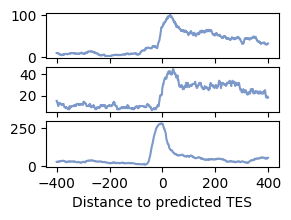

In [1495]:
fig, axes = plt.subplots(3,1,figsize=(3,2))
axes[1].plot(np.arange(-400,400),bsub_metagene,color="#7C99C9")
_ = axes[1].set_xticklabels([])
axes[0].plot(np.arange(-400,400),ecoli_metagene,color="#7C99C9")
_ = axes[0].set_xticklabels([])
axes[2].plot(np.arange(-400,400),nostoc_metagene,color="#7C99C9")
axes[2].set_xlabel("Distance to predicted TES")
plt.savefig("figures/model-species-density2.pdf",bbox_inches="tight")

In [1520]:
def check_cyano_RUT(asm_id,plot=False,name=None):
    indir = "/BioII/lulab_b/jinyunfan/projects/terminator-prediction/rho-protein-phylogenetics/genomes/cyanobacteria"    
    contig_path = f"{indir}/assemblies-short/{asm_id}.fna.fai"
    fpr_path = f"{indir}/RUT-background/{asm_id}.FPR"
    rut_path = f"{indir}/RUT/{asm_id}.max.bed"
    stem_loop_path = f"{indir}/stem-loops/bed.annotated/{asm_id}.bed"
    cds_path = f"{indir}/genes/{asm_id}.bed"
    left_flanking,right_flanking = 400,400
    metagene, metagene_start, metagene_end, n_with_RDT, n_terminator, n_RUTs, size = get_metagene(contig_path, fpr_path, rut_path,stem_loop_path,cds_path,
                     threshold=0.2,left_flanking=left_flanking, right_flanking=right_flanking)
    if plot:
        fig, ax = plt.subplots(figsize=(5,1))
        ax.plot(np.arange(-200,400),metagene[200:],
                label="stem loop",linewidth=2,color="#7C99C9")
        ax.set_xlabel("Distance to predicted primary termination sites")
        ax.set_ylabel("Density")
        if name is not None:
            ax.set_title(name)
        ax.set_xlim([-200,400])
        plt.savefig(f"figures/{asm_id}.pdf",bbox_inches="tight")
    return n_with_RDT/n_terminator, n_RUTs/(size/1000)

In [1499]:
#traits = traits.reset_index()

(0.139739663093415, 0.7316414189878969)

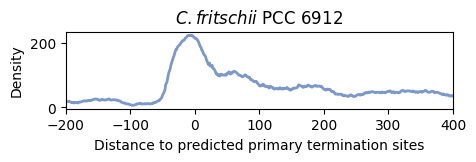

In [1521]:
check_cyano_RUT("GCF_003990575.1",plot=True,name="$C. fritschii$ PCC 6912")

(0.17749887942626624, 0.8061384204394337)

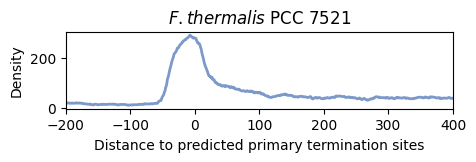

In [1522]:
check_cyano_RUT("GCF_000317225.1",plot=True,name="$F. thermalis$ PCC 7521")

(0.22945484133441824, 0.7835817947590277)

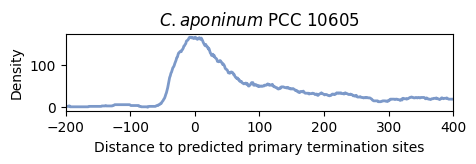

In [1523]:
#Cyanobacterium.aponinum.PCC.10605__Cyanobacteriaceae__GCF_000317675.1
check_cyano_RUT("GCF_000317675.1",plot=True,name="$C. aponinum$ PCC 10605")

(0.06930693069306931, 0.503360780548145)

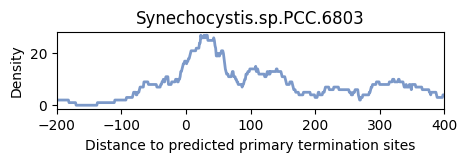

In [1524]:
#Synechocystis.sp.PCC.6803.substr.GT-I__Microcystaceae_A__GCF_000284135.1
check_cyano_RUT("GCF_000284135.1",plot=True,name="Synechocystis.sp.PCC.6803")

(0.021834061135371178, 0.6868694433198144)

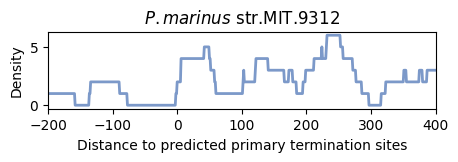

In [1525]:
#Prochlorococcus.marinus.str.MIT.9312__Cyanobiaceae__GCF_000012645.1
check_cyano_RUT("GCF_000012645.1",plot=True,name="$P. marinus$ str.MIT.9312")

(0.04672897196261682, 0.5670486739265915)

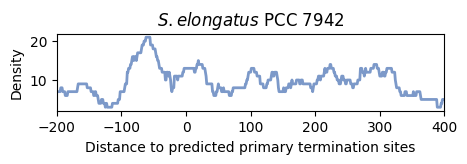

In [1526]:
#GCF_000012525.1 GCA_000012525.1 Synechococcus elongatus PCC 7942 
check_cyano_RUT("GCF_000012525.1",plot=True,name="$S. elongatus$ PCC 7942")

(0.04374240583232078, 0.46276541928218573)

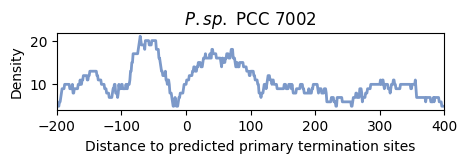

In [1542]:
#Picosynechococcus.sp.PCC.7002__Cyanobacteriaceae__GCF_000019485.1
check_cyano_RUT("GCF_000019485.1",plot=True,name="$P. sp.$ PCC 7002")

(0.21272285251215559, 0.8168041377202027)

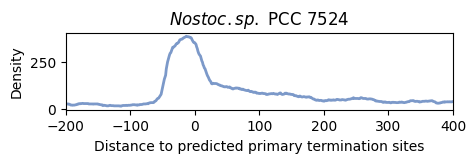

In [1545]:
#Nostoc.sp.PCC.7524__Nostocaceae__GCF_000316645.1
check_cyano_RUT("GCF_000316645.1",plot=True,name="$Nostoc. sp.$ PCC 7524")

In [1527]:
fractions_in_TES = {}
RDT_densities = {}
for refseq_id, species, unicellular in traits.loc[:,["refseq id","species",'03 UNICELLULAR']].to_records(index=False):
    if not os.path.exists(f"data/cyanobacteria/bed.annotated/{refseq_id}.bed"):
        #print(refseq_id)
        continue
    fraction_in_TES, RDT_density = check_cyano_RUT(refseq_id)
    #print(refseq_id, species, unicellular, fraction)
    fractions_in_TES[refseq_id] = fraction_in_TES
    RDT_densities[refseq_id] = RDT_density

In [1528]:
traits["RDT fraction"] = traits["refseq id"].map(lambda x:fractions_in_TES.get(x,np.nan))
traits["RDT density"] = traits["refseq id"].map(lambda x:RDT_densities.get(x,np.nan))

In [1529]:
traits[~traits["RDT density"].isna()].to_csv("cyano-traits-with-complete-genomes.txt",sep="\t",index=False)

In [1530]:
with open("cyano-complete-genome-ids.txt","w") as f:
    f.write("\n".join(traits[~traits["RDT density"].isna()]['refseq id'].values))

In [1531]:
genome_ids = set(list(traits[~traits["RDT density"].isna()]['refseq id'].values))

In [1532]:
cyanobacteria_msa = "/BioII/lulab_b/jinyunfan/projects/terminator-prediction/rho-protein-phylogenetics/genomes/cyanobacteria/taxonomy/align/gtdbtk.bac120.user_msa.renamed.fasta"
fout = open("cyanobacteria-with-complete-genome-and-traits.marker120.faa","w")
with open(cyanobacteria_msa) as f:
    for header in f:
        sequence = next(f)
        asm_id = header.strip().split("__")[-1]
        if asm_id in genome_ids:
            rename[asm_id] = header[1:-1]
            fout.write(header)
            fout.write(sequence)
fout.close()
# manually edit two label
#Synechococcus.sp.JA-2-3B'a(2-13)__JA-3-3Ab__GCF_000013225.1->
#Synechococcus.sp.JA-2-3B'a2-13__JA-3-3Ab__GCF_000013225.1
#[Leptolyngbya].sp.PCC.7376__Cyanobacteriaceae__GCF_000316605.1 -> 
#sp.PCC.7376__Cyanobacteriaceae__GCF_000316605.1

In [1354]:
#FastTree -wag -gamma cyanobacteria-with-complete-genome-and-traits.marker120.faa > cyanobacteria-with-complete-genome-and-traits.marker120.nwk

In [26]:
rename = {}
with open("cyanobacteria-with-complete-genome-and-traits.marker120.faa") as f:
    for header in f:
        sequence = next(f)
        asm_id = header.strip().split("__")[-1]
        rename[asm_id] = header[1:-1]

In [1534]:
traits = traits.set_index('refseq id')

In [1535]:
fout = open("itol-datasets/cyanobacteria-RUT-fraction.txt","w")
header = """DATASET_SIMPLEBAR

SEPARATOR COMMA
DATASET_LABEL,simple bar RUT fraction

DATASET_SCALE,0-line 1-#dddddd-1-1-1,0.1-line 2-#dddddd-1-1-1,0.2-line 3-#dddddd-1-1-1
COLOR,#8e7cc3
WIDTH,100

HEIGHT_FACTOR,1

DATA"""
print(header,file=fout)
for otu_id in rename:
    name = rename[otu_id]
    v = round(traits.loc[otu_id,"RDT fraction"],3)
    print(name,v,sep=",",file=fout)
fout.close()

In [1537]:
fout = open("itol-datasets/cyanobacteria-unicellular.txt","w")
header = """DATASET_BINARY
SEPARATOR COMMA
DATASET_LABEL,unicellular
COLOR,#ff0000
FIELD_SHAPES,1
FIELD_LABELS,unicellular
DATA"""
print(header,file=fout)
#node 9606 will have a filled circle, outline of a left triangle, nothing in the 3rd column and an rectangle outline in column 4
#9606,1,0,-1,0
for otu_id in rename:
    name = rename[otu_id]
    v = int(traits.loc[otu_id,"03 UNICELLULAR"])
    print(name,v,sep=",",file=fout)
fout.close()

In [1538]:
fout = open("itol-datasets/cyanobacteria-marine.txt","w")
header = """DATASET_BINARY
SEPARATOR COMMA
DATASET_LABEL,marine
COLOR,#ff0000
FIELD_SHAPES,1
FIELD_LABELS,marine
DATA"""
print(header,file=fout)
#node 9606 will have a filled circle, outline of a left triangle, nothing in the 3rd column and an rectangle outline in column 4
#9606,1,0,-1,0
for otu_id in rename:
    name = rename[otu_id]
    v = int(1-traits.loc[otu_id,"01 NON MARINE"])
    print(name,v,sep=",",file=fout)
fout.close()

In [1539]:
fout = open("itol-datasets/cyanobacteria-no-N-fixation.txt","w")
header = """DATASET_BINARY
SEPARATOR COMMA
DATASET_LABEL,no-N-fixation
COLOR,#ff0000
FIELD_SHAPES,1
FIELD_LABELS,no-N-fixation
DATA"""
print(header,file=fout)
#node 9606 will have a filled circle, outline of a left triangle, nothing in the 3rd column and an rectangle outline in column 4
#9606,1,0,-1,0
for otu_id in rename:
    name = rename[otu_id]
    v = int(traits.loc[otu_id,"02 NO N FIXATION"])
    print(name,v,sep=",",file=fout)
fout.close()

In [1408]:
from scipy.stats import ttest_ind

In [1540]:
traits[~traits["RDT fraction"].isna()].loc[:,["01 NON MARINE","02 NO N FIXATION","03 UNICELLULAR","RDT fraction"]].to_csv("metadata-complete-cleaned.txt",sep="\t")

In [7]:
cd /BioII/lulab_b/jinyunfan/projects/terminator-prediction/terminator-evoluationary-analysis

/BioII/lulab_b/jinyunfan/projects/terminator-prediction/terminator-evoluationary-analysis


In [8]:
traits = pd.read_csv("metadata-complete-cleaned.txt",sep="\t",index_col=0)

In [9]:
traits

,01 NON MARINE,02 NO N FIXATION,03 UNICELLULAR,RDT fraction
refseq id,,,,
GCF_000012525.1,1,1,1,0.046729
GCF_000010625.1,1,1,1,0.148220
GCF_000020025.1,1,0,0,0.142439
GCF_000011345.1,1,1,1,0.035714
GCF_000011385.1,1,1,1,0.069853
...,...,...,...,...
GCF_000195975.1,0,1,1,0.066158
GCF_000316685.1,1,1,1,0.106557
GCF_000012625.1,0,1,1,0.050781


In [12]:
FarLIP_species = open("../rho-protein-phylogenetics/FARLip.species.txt").read().strip().split("\n")

In [17]:
genome_ids = np.intersect1d(FarLIP_species,traits.index)

In [23]:
traits["FaRLiP"] = traits.index.isin(genome_ids).astype(int)

In [29]:
LoLip_species = open("../rho-protein-phylogenetics/LoLip.species.txt").read().strip().split("\n")
genome_ids = np.intersect1d(LoLip_species,traits.index)
traits["LoLiP"] = traits.index.isin(genome_ids).astype(int)

In [27]:
fout = open("itol-datasets/cyanobacteria-FaRLiP.txt","w")
header = """DATASET_BINARY
SEPARATOR COMMA
DATASET_LABEL,FaRLiP
COLOR,#ff0000
FIELD_SHAPES,1
FIELD_LABELS,FaRLiP
DATA"""
print(header,file=fout)
#node 9606 will have a filled circle, outline of a left triangle, nothing in the 3rd column and an rectangle outline in column 4
#9606,1,0,-1,0
for otu_id in rename:
    name = rename[otu_id]
    v = int(traits.loc[otu_id,"FaRLiP"])
    print(name,v,sep=",",file=fout)
fout.close()

In [34]:
fout = open("itol-datasets/cyanobacteria-LoLip.txt","w")
header = """DATASET_BINARY
SEPARATOR COMMA
DATASET_LABEL,LoLip
COLOR,#ff0000
FIELD_SHAPES,1
FIELD_LABELS,LoLip
DATA"""
print(header,file=fout)
#node 9606 will have a filled circle, outline of a left triangle, nothing in the 3rd column and an rectangle outline in column 4
#9606,1,0,-1,0
for otu_id in rename:
    name = rename[otu_id]
    v = int(traits.loc[otu_id,"LoLiP"])
    print(name,v,sep=",",file=fout)
fout.close()

In [ ]:
#apcD4-apcB3-isiX
#apcB3 WP_016874155.1

In [46]:
hfq_species = open("hfq.species.2.txt").read().strip().split("\n")
genome_ids = np.intersect1d(hfq_species,traits.index)
traits["hfq"] = traits.index.isin(genome_ids).astype(int)

In [47]:
fout = open("itol-datasets/cyanobacteria-hfq2.txt","w")
header = """DATASET_BINARY
SEPARATOR COMMA
DATASET_LABEL,hfq
COLOR,#ff0000
FIELD_SHAPES,1
FIELD_LABELS,hfq
DATA"""
print(header,file=fout)
#node 9606 will have a filled circle, outline of a left triangle, nothing in the 3rd column and an rectangle outline in column 4
#9606,1,0,-1,0
for otu_id in rename:
    name = rename[otu_id]
    v = int(traits.loc[otu_id,"hfq"])
    print(name,v,sep=",",file=fout)
fout.close()